---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [157]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [155]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))

for graph in P1_Graphs:
    print(nx.info(graph),'\n')

Name: barabasi_albert_graph(1000,2)
Type: Graph
Number of nodes: 1000
Number of edges: 1996
Average degree:   3.9920 

Name: watts_strogatz_graph(1000,10,0.05)
Type: Graph
Number of nodes: 1000
Number of edges: 5000
Average degree:  10.0000 

Name: watts_strogatz_graph(750,5,0.075)
Type: Graph
Number of nodes: 750
Number of edges: 1500
Average degree:   4.0000 

Name: barabasi_albert_graph(750,4)
Type: Graph
Number of nodes: 750
Number of edges: 2984
Average degree:   7.9573 

Name: watts_strogatz_graph(750,4,1)
Type: Graph
Number of nodes: 750
Number of edges: 1500
Average degree:   4.0000 



<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [89]:
def define_graph_type(graphs):
    """
    Define graph type
    """
    
    for idx,graph in enumerate(graphs):
        print('Graph {}: {}'.format(idx,type(graph)))

In [68]:
# define_graph_type(P1_Graphs)

Graph 0: <class 'networkx.classes.graph.Graph'>
Graph 1: <class 'networkx.classes.graph.Graph'>
Graph 2: <class 'networkx.classes.graph.Graph'>
Graph 3: <class 'networkx.classes.graph.Graph'>
Graph 4: <class 'networkx.classes.graph.Graph'>


In [90]:
def degree_histogram(graph):
    """
    Compute histogram of degree distribution
    """
    # compute node degree
    degrees = graph.degree()
    degree_values = sorted(set(degrees.values()))
    
    # compute histogram
    histogram = [list(degrees.values()).count(i) / float(nx.number_of_nodes(graph)) for i in degree_values]
    
    return histogram

In [91]:
def plot_degree_distribution(graphs):
    """
    Compute and plot histogram of degree distribution of graph G.
    """ 
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    fig, axs = plt.subplots(2,3,figsize=(16,12))
    
    for idx, graph in enumerate(graphs):
    
        # compute node degree
        degrees = graph.degree()
        degree_values = sorted(set(degrees.values()))
        
        # compute histogram
        histogram = [list(degrees.values()).count(i) / float(nx.number_of_nodes(graph)) for i in degree_values]
        
        # plot
        axs[idx//3,idx%3].plot(degree_values, histogram,'o')
        
        # set labels
        axs[idx//3,idx%3].set_xlabel('Degree')
        axs[idx//3,idx%3].set_ylabel('Fraction of Nodes')
        
        # set scale to log
        axs[idx//3,idx%3].set_xscale('log')
        axs[idx//3,idx%3].set_yscale('log')
        
        # set plot title
        axs[idx//3,idx%3].set_title("Graph {}".format(idx))
    
    # delete 6th axis
    axs[-1, -1].axis('off')

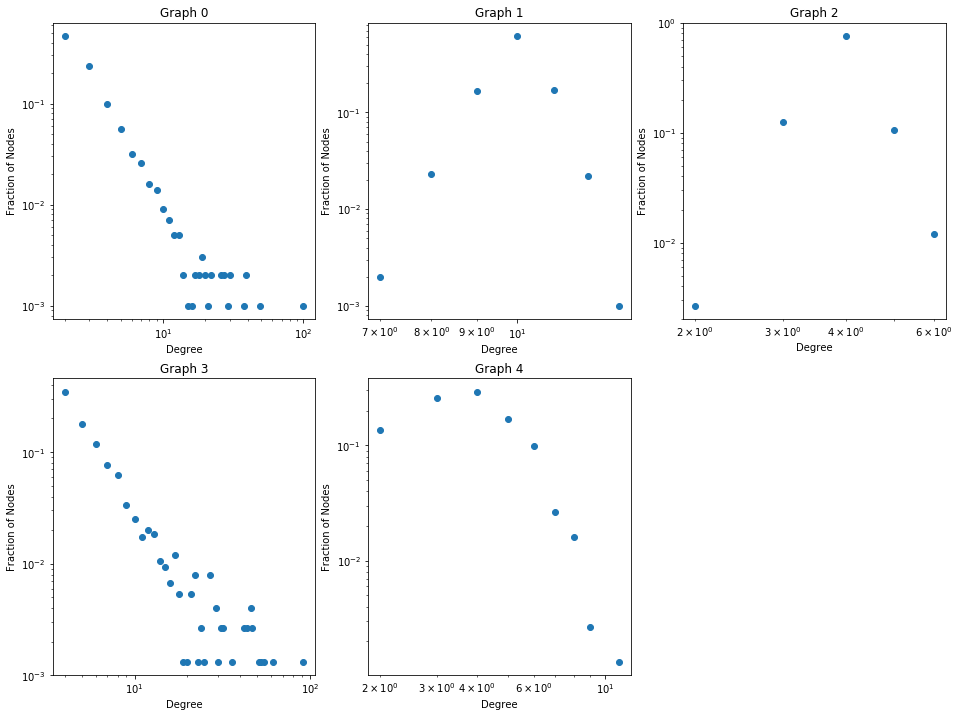

In [70]:
# degree_distribution(P1_Graphs)

In [92]:
def graph_identification():
    
    classification = []
    
    for idx,G in enumerate(P1_Graphs):
        clustering = nx.average_clustering(G)
        shortest_path = nx.average_shortest_path_length(G)
        degree_hist = len(degree_histogram(G))
        
        if degree_hist>10:
            classification.append('PA')
        elif clustering<0.1:
            classification.append('SW_H')
        else:
            classification.append('SW_L')
    
    return classification

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [166]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [165]:
def salary_predictions():
    
    """
    Using network G, identify the people in the network with missing values for the node attribute ManagementSalary
    and predict whether or not these individuals are receiving a management position salary.
    """
    
    # import libraries and modules
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.ensemble import RandomForestClassifier
        
    # convert network into dataframe
    # rows are nodes, columns are connected nodes
    df = nx.to_pandas_dataframe(G)
    
    # create new features
    # 1.   degree
    df['degree'] = pd.Series(nx.degree(G))
    
    # 2.   betweenness
    df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
    
    # 3.   Department
    df['Department'] = pd.Series({tup[0]:tup[1]['Department'] for tup in G.nodes(data=True)})

    # 4.   degree_centrality
    df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    
    # 5.   closeness
    df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
    
    # 6.   clustering
    df['clustering'] = pd.Series(nx.clustering(G))
    
    # target feature
    df['ManagementSalary'] = pd.Series({tup[0]:tup[1]['ManagementSalary'] for tup in G.nodes(data=True)})
    
    # convert to dummies
    features = ['degree','betweenness','Department','degree_centrality','closeness','clustering','ManagementSalary']
    df = df[features]
    df = pd.get_dummies(df, columns=['Department'])
    
    # isolate train and test set
    df_train = df[~pd.isnull(df['ManagementSalary'])]
    df_test = df[pd.isnull(df['ManagementSalary'])]
    
    # normalize data
    X_train = df_train[df_train.columns.difference(['ManagementSalary'])]
    y_train = df_train['ManagementSalary']
    X_test = df_test[df_test.columns.difference(['ManagementSalary'])]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # build and fit model
    model = RandomForestClassifier()           
    model.fit(X_train_scaled, y_train)
    
    # make predictions
    test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    return pd.Series(test_proba,X_test.index)

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [167]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [ ]:
def new_connections_predictions():
    
    """
    Using network G and future_connections, identify the edges in future_connections with missing
    values and predict whether or not these edges will have a future connection.
    """
    
    # import libraries and modules
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.ensemble import RandomForestClassifier
    
    # add information regarding the community to G
    
    future_connections
    
    # community
    for node in G.nodes():
        G.node[node]['community'] = G.node[node]['Department']
    
    # compute edge properties and generate new features
    
    # 1.   Preferential Attachment (& create initial dataframe)
    preferential_attachment = list(nx.preferential_attachment(G))
    
    df = pd.DataFrame(index=[(e[0], e[1]) for e in preferential_attachment])
    df['preferential_attachment'] = [e[2] for e in preferential_attachment]
    df['n1'] = [e[0] for e in preferential_attachment]
    df['n2'] = [e[1] for e in preferential_attachment]
    
    # 2.   Common Neighbors
    df['common_neigh'] = df.apply(lambda x: len(list(nx.common_neighbors(G,x['n1'],x['n2']))),axis=1) 
    
    # 3.   Jaccard Coef.
    df['jaccard_coefficient'] = [e[2] for e in list(nx.jaccard_coefficient(G))]
    
    # 4.   Ressource Alloc.
    df['resource_allocation_index'] = [e[2] for e in list(nx.resource_allocation_index(G))]
    
    # 5.   Adamic-Adar Index
    df['adamic_adar_idx'] = [e[2] for e in list(nx.adamic_adar_index(G))]
    
    # 6.   Community
    cn_soundarajan_hopcroft = list(nx.cn_soundarajan_hopcroft(G))
    df_cn_soundarajan_hopcroft = pd.DataFrame(index=[(e[0], e[1]) for e in cn_soundarajan_hopcroft])
    df_cn_soundarajan_hopcroft['cn_soundarajan_hopcroft'] = [e[2] for e in cn_soundarajan_hopcroft]
    df = df.join(df_cn_soundarajan_hopcroft,how='outer')
    df['cn_soundarajan_hopcroft'] = df['cn_soundarajan_hopcroft'].fillna(value=0)
    
    # 7.   Community Ressource Alloc
    ra_index_soundarajan_hopcroft = list(nx.ra_index_soundarajan_hopcroft(G))
    df_ra_index_soundarajan_hopcroft = pd.DataFrame(index=[(e[0], e[1]) for e in ra_index_soundarajan_hopcroft])
    df_ra_index_soundarajan_hopcroft['ra_index_soundarajan_hopcroft'] = [e[2] for e in ra_index_soundarajan_hopcroft]
    df = df.join(df_ra_index_soundarajan_hopcroft,how='outer')
    df['ra_index_soundarajan_hopcroft'] = df['ra_index_soundarajan_hopcroft'].fillna(value=0)
    
    # build model
    df = future_connections.join(df,how='outer')
    
    # isolate train and test set
    df_train = df[~pd.isnull(df['Future Connection'])]
    df_test = df[pd.isnull(df['Future Connection'])]
    
    # normalize data
    X_train = df_train[df_train.columns.difference(['Future Connection'])]
    y_train = df_train['Future Connection']
    X_test = df_test[df_test.columns.difference(['Future Connection'])]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # build and fit model
    model = RandomForestClassifier()           
    model.fit(X_train_scaled, y_train)
    
    # make predictions
    test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    return pd.Series(test_proba,X_test.index)